## Kue Dataset - Model3


In [6]:
# conda install -c conda-forge keras

In [7]:
import os
import re
import glob

import scipy.io
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.io import loadmat
import random
import sklearn
import seaborn as sns

In [8]:
# PATH_DATA = '../data/'
PATH_DATA_IMAGES = '../../dataset257/'
PATH_DATA_TRAIN = PATH_DATA_IMAGES+'train/'
PATH_DATA_VAL = PATH_DATA_IMAGES+'validation/'
PATH_DATA_TEST = PATH_DATA_IMAGES+'test/'
PATH_MODEL = '../../tmp/'

In [9]:
os.listdir(PATH_DATA_TRAIN)

['kue_kastengel',
 'kue_dadar_gulung',
 'kue_klepon',
 'kue_risoles',
 'kue_lumpur',
 'kue_serabi',
 'kue_lapis',
 'kue_putri_salju']

## Modeling

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model


Using TensorFlow backend.


In [11]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [12]:
## label dict
lab = [i for i in os.listdir(PATH_DATA_TRAIN) if '.' not in i]
lab.sort()

label_dict = dict(zip(lab,[i for i in range(len(lab))]))
label_dict

{'kue_dadar_gulung': 0,
 'kue_kastengel': 1,
 'kue_klepon': 2,
 'kue_lapis': 3,
 'kue_lumpur': 4,
 'kue_putri_salju': 5,
 'kue_risoles': 6,
 'kue_serabi': 7}

In [13]:
LABEL_SIZE = len(label_dict.keys())
IMAGE_SIZE = 128

In [14]:
just_cake_model = Sequential()
just_cake_model.add(Conv2D(64, (3, 3), activation ='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
just_cake_model.add(Conv2D(16, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Conv2D(4, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))

just_cake_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
just_cake_model.add(Dense(512, activation ='relu'))
just_cake_model.add(Dense(128, activation ='relu'))
just_cake_model.add(Dense(LABEL_SIZE,activation ='softmax'))

In [15]:
just_cake_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 16)      9232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 4)         580       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)              

In [16]:
## compile model
opt = optimizers.Adam(learning_rate=0.0001)
just_cake_model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer = opt,
              metrics=['accuracy',metrics.AUC()])

In [17]:
## data generator
BATCH_SIZE = 64
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=35,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.25,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        PATH_DATA_TRAIN,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        class_mode="categorical" )  

val_generator = val_datagen.flow_from_directory(
        PATH_DATA_VAL,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        class_mode="categorical" )  

test_generator = test_datagen.flow_from_directory(
        PATH_DATA_TEST,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical" )

Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [ ]:
## save best model and use early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=8) 
check_p = tf.keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'just_cake_model_checkpoint3.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

epoch_hist = just_cake_model.fit(
        train_generator,
        steps_per_epoch=1516 // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=160 // BATCH_SIZE,
        callbacks=[early_stop,check_p],
        epochs=250)

Epoch 1/250
23/23 [==============================] - 41s 2s/step - loss: 2.0775 - accuracy: 0.1253 - auc_1: 0.5164 - val_loss: 2.0700 - val_accuracy: 0.1250 - val_auc_1: 0.5341
Epoch 2/250
23/23 [==============================] - 37s 2s/step - loss: 2.0506 - accuracy: 0.1667 - auc_1: 0.5851 - val_loss: 2.0122 - val_accuracy: 0.2083 - val_auc_1: 0.6283
Epoch 3/250
23/23 [==============================] - 35s 2s/step - loss: 1.9283 - accuracy: 0.2052 - auc_1: 0.6866 - val_loss: 1.8042 - val_accuracy: 0.2917 - val_auc_1: 0.7681
Epoch 4/250
23/23 [==============================] - 37s 2s/step - loss: 1.7806 - accuracy: 0.2568 - auc_1: 0.7422 - val_loss: 1.6944 - val_accuracy: 0.3516 - val_auc_1: 0.7884
Epoch 5/250
23/23 [==============================] - 37s 2s/step - loss: 1.7221 - accuracy: 0.2891 - auc_1: 0.7612 - val_loss: 1.5575 - val_accuracy: 0.4167 - val_auc_1: 0.8111
Epoch 6/250
23/23 [==============================] - 36s 2s/step - loss: 1.6915 - accuracy: 0.2996 - auc_1: 0.7721 

## Evaluations

In [21]:
df_epoch_hist = pd.DataFrame(epoch_hist.history)

NameError: name 'epoch_hist' is not defined

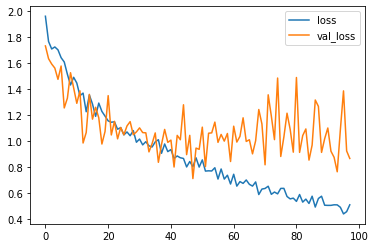

In [15]:
df_epoch_hist[['loss','val_loss']].plot()

In [16]:
df_epoch_hist.to_csv('../artifact/epoch_hist_3.csv')

In [17]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'just_cake_model_checkpoint3.h5',compile=False)

In [18]:
true_labels = val_generator.classes
predictions = model_load.predict(val_generator)

y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

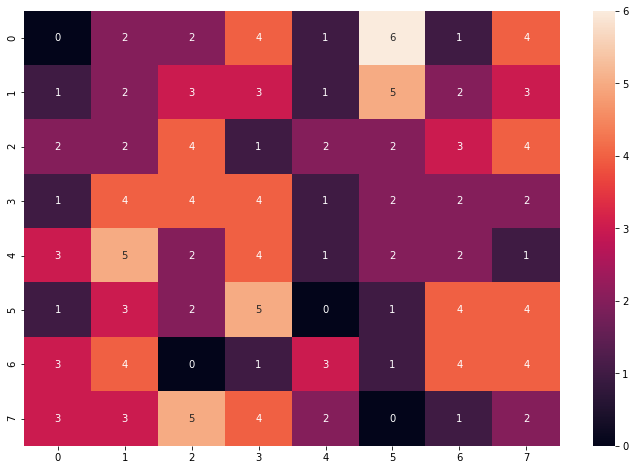

In [19]:
plt.figure(figsize = (12,8))
sns.heatmap(cm, annot= True)

In [20]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.08      0.10      0.09        20
           2       0.18      0.20      0.19        20
           3       0.15      0.20      0.17        20
           4       0.09      0.05      0.06        20
           5       0.05      0.05      0.05        20
           6       0.21      0.20      0.21        20
           7       0.08      0.10      0.09        20

    accuracy                           0.11       160
   macro avg       0.11      0.11      0.11       160
weighted avg       0.11      0.11      0.11       160

